#Курсовая работа
##по дисциплине «Технологии анализа данных и машинное обучение»
####на тему: «Предварительный анализ данных и построение признаков в задачах распознавания темы текста»


##Загрузка данных

In [ ]:
#!pip install gensim --upgrade

In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Dataset/data/'
fairy_tales = []

file_names = os.listdir(DATA_PATH)
for file_name in file_names:
    with open(DATA_PATH + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
    fairy_tales.append(data)
len(fairy_tales)

1455

##Предобработка данных

В первую очередь необходимо удалить слова-"выбросы". Поскольку тексты взяты из книг со сказками, то во всех них присутствуют такие слова как "Illustration", "Chapter", "Decoration" (это обозначения элементов в книгах). Для распознавания темы текстов они бесполезны.

In [ ]:
import re

for text in fairy_tales:
    
    chapter_pattern=re.compile(r'(CHAPTER [A-Z]+)|([Cc]hapter [A-Z]+)')
    decoration_pattern=re.compile(r'(\[Decoration])|(Decoration)')
    ill_pattern=re.compile(r'(\[Illustration:?[\s\w]*])|(Illustration)')
    text = re.sub(chapter_pattern, '', text)
    text = re.sub(ill_pattern, '', text)
    text = re.sub(decoration_pattern, '', text)

Далее общая предобработка данных: очистка от не английских букв (Æ, Œ, Ö, Å и т.д.), от html-тэгов, от специальных символов (~, *, $ и т. д.), от соединений (I'm, he'll, we'd и т. д.), от повторов символов, от стоп-слов, от чисел. Также будет проведена лемматизация слов.

In [ ]:
from string import punctuation
import nltk

In [ ]:
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [ ]:
import re
from bs4 import BeautifulSoup

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

In [ ]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [ ]:
from nltk.corpus import wordnet

def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

In [ ]:
import spacy
# use spacy.load('en') if you have downloaded the language model en directly after install spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
def remove_stopwords(text, is_lower_case=False, stopwords=stopword_list):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        #if contraction_expansion:
            #doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([[{.(-)!_}\]])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = re.sub(special_char_pattern, "", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [ ]:
# Дополнительная функция предобработки с RegexpTokenizer и WordNetLemmatizer,
# ещё одно удаление стоп-слов для улучшения набора данных и рез-тов моделирования

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
stop_words = nltk.corpus.stopwords.words('english')

wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus_2(texts):
  norm_texts = []
  for text in texts:
    text = text.lower()
    paper_tokens = [token.strip() for token in wtk.tokenize(text)]
    paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
    paper_tokens = [token for token in paper_tokens if len(token) > 1]
    paper_tokens = [token for token in paper_tokens if token not in stop_words]
    paper_tokens = list(filter(None, paper_tokens))
    if paper_tokens:
      norm_texts.append(paper_tokens)
  return norm_texts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
norm_fairy_tales = list(filter(None, normalize_corpus(fairy_tales)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Possible nested set at position 2


In [ ]:
norm_fairy_tales_no_lemm = list(filter(None, normalize_corpus(fairy_tales, text_lemmatization=False)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Possible nested set at position 2


##Извлечение ключевых фраз (keyphrases)

###Collocations (N-grams)

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# bigrams
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures as bigram_measures

finder = BigramCollocationFinder.from_documents([word_tokenize(tale) 
                                                    for tale in norm_fairy_tales_no_lemm])
finder

In [ ]:
finder.nbest(bigram_measures.raw_freq, 10)

[('old', 'man'),
 ('old', 'woman'),
 ('one', 'day'),
 ('can', 'not'),
 ('young', 'man'),
 ('next', 'morning'),
 ('next', 'day'),
 ('let', 'us'),
 ('long', 'time'),
 ('could', 'see')]

In [ ]:
finder = BigramCollocationFinder.from_documents([word_tokenize(tale) 
                                                    for tale in norm_fairy_tales_no_lemm[:5]])
finder

In [ ]:
finder.nbest(bigram_measures.raw_freq, 10)

[('earl', 'st'),
 ('st', 'clair'),
 ('earl', 'gregory'),
 ('old', 'woman'),
 ('peerie', 'folk'),
 ('robin', 'redbreast'),
 ('elfin', 'king'),
 ('kings', 'palace'),
 ('thou', 'wilt'),
 ('elder', 'sister')]

In [ ]:
# trigrams
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures as trigram_measures

finder = TrigramCollocationFinder.from_documents([word_tokenize(tale) 
                                                    for tale in norm_fairy_tales_no_lemm])

In [ ]:
finder.nbest(bigram_measures.raw_freq, 10)

[('said', 'old', 'woman'),
 ('said', 'old', 'man'),
 ('let', 'us', 'go'),
 ('sun', 'wu', 'kung'),
 ('old', 'man', 'said'),
 ('upon', 'time', 'lived'),
 ('old', 'woman', 'said'),
 ('early', 'next', 'morning'),
 ('little', 'old', 'woman'),
 ('says', 'old', 'man')]

In [ ]:
finder = TrigramCollocationFinder.from_documents([word_tokenize(tale) 
                                                    for tale in norm_fairy_tales_no_lemm[:5]])

In [ ]:
finder.nbest(bigram_measures.raw_freq, 10)

[('earl', 'st', 'clair'),
 ('cold', 'winters', 'day'),
 ('good', 'morning', 'robin'),
 ('mayest', 'thou', 'going'),
 ('merry', 'yule', 'morning'),
 ('morning', 'robin', 'redbreast'),
 ('sing', 'song', 'merry'),
 ('song', 'merry', 'yule'),
 ('day', 'im', 'road'),
 ('early', 'cold', 'winters')]

###Weighted Tag-Based Phrase Extraction (TF-IDF)

In [ ]:
from gensim.summarization import keywords
for i in range(5):
  key_words = keywords(norm_fairy_tales[i], ratio=1.0, scores=True, lemmatize=False)
  res = str([(item, round(score, 3)) for item, score in key_words][:10])
  print(f"Ключевые фразы для сказки №{i+1}: {res}")

Ключевые фразы для сказки №1: [('coming', 0.203), ('thou sayest', 0.14), ('young earl', 0.125), ('haunt elfin knight', 0.114), ('man', 0.114), ('till', 0.099), ('clair', 0.096), ('follow', 0.094), ('follower', 0.094), ('step', 0.092)]
Ключевые фразы для сказки №2: [('talking', 0.122), ('glen', 0.122), ('brownie know scotland story write', 0.111), ('tell', 0.106), ('reply', 0.083), ('look good turn need assistance farmer', 0.082), ('wife leave door barn', 0.08), ('send old woman live seven', 0.079), ('ask wage', 0.077), ('lady', 0.074)]
Ключевые фразы для сказки №3: [('lady', 0.164), ('ambassador', 0.138), ('eld sister', 0.135), ('lovely little glass shoe', 0.128), ('bride', 0.126), ('fit tiny foot imaginable', 0.104), ('sea dwelt great mighty prince live grand castle', 0.1), ('order', 0.096), ('laird', 0.093), ('lord courtier tell determination come', 0.091)]
Ключевые фразы для сказки №4: [('peerie folk', 0.112), ('daughter young princess grow', 0.105), ('feed cabbage', 0.097), ('littl

Можно увидеть, что ключевые фразы и для всего набора данных (1455 сказок), и просто для 5 сказок хотя и передают какую-то часть их содержания, но можно примерно догадаться, о чём пойдёт речь, только в случае с ключевыми фразами для 5 сказок (lady, Robin Redbreast, King's palace). Однако этого всё равно не достаточно, чтобы сделать вывод о темах текстов. Поэтому стоит обратиться к моделям из семейства Topic Modeling.

##Topic Modeling

###Построение признаков

In [ ]:
# Дополнительная обработка данных перед Topic Modeling для улучшения результатов

norm_fairy_tales_tkn = normalize_corpus_2(norm_fairy_tales)

In [ ]:
# Построение Bigrams фраз из корпуса

import gensim
bigram = gensim.models.Phrases(norm_fairy_tales_tkn, min_count=15, threshold=15,
                              delimiter='_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

In [ ]:
print(bigram_model[norm_fairy_tales_tkn[0]][:50])

# Модель поделила тексты на Bigrams - самостоятельные слова остались отдельно
# А фразы слились (seven_year, shake_head и т.д.)

['lone', 'moor', 'scotland', 'time', 'past', 'say', 'haunt', 'elfin', 'knight', 'knight', 'see', 'rare', 'interval', 'every', 'seven_year', 'fear', 'lie', 'country', 'round', 'every', 'someone', 'would', 'set', 'cross', 'moor', 'would', 'never', 'hear', 'although', 'man', 'may', 'search', 'every', 'inch', 'ground', 'trace', 'would', 'find', 'thrill', 'horror', 'search', 'party', 'would', 'go', 'home', 'shake_head', 'whisper', 'one', 'another', 'fall']


In [ ]:
norm_corpus_bigrams = [bigram_model[tale] for tale in norm_fairy_tales_tkn]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)

In [ ]:
print('Пример записей из словаря:', list(dictionary.items())[50:55])
print('Размер словаря:', len(dictionary))

Пример записей из словаря: [(50, 'black'), (51, 'bless'), (52, 'blessed'), (53, 'block'), (54, 'blood')]
Размер словаря: 25743


In [ ]:
# Для уменьшения масштабов словаря и поиска уникальных тем уберём слова, 
# встретившиеся по всему набору данных менее 20 раз 
# а также те слова, которые появились в более 60% текстов
# Позже путём перебора были выявлены более подходящие значения для набора данных - 15 и 75% 

dictionary.filter_extremes(no_below=15, no_above=0.75)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 4963


In [ ]:
# Создание Bag of Words из полученного словаря

bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][50:60])

[(215, 2), (216, 2), (221, 1), (222, 1), (224, 1), (229, 1), (231, 4), (232, 1), (233, 1), (234, 1)]


In [ ]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][50:60]])

[('hear', 2), ('heart', 2), ('help', 1), ('hide', 1), ('hither', 1), ('home', 1), ('horse', 4), ('horseman', 1), ('hour', 1), ('however', 1)]


In [ ]:
# Проверка: длина bow_corpus должна быть равна количеству текстов

print(len(bow_corpus))

1455


###Latent Semantic Indexing (LSI)

In [ ]:
# Предположительно в наборе текстов можно выделить 10 тем, позже этот гиперпараметр будет скорректирован

TOTAL_TOPICS = 10

In [ ]:
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, 
                                 num_topics=TOTAL_TOPICS, onepass=True, chunksize=1455, power_iters=1500)

In [ ]:
# Термины из полученных 10 тем

for n in range(TOTAL_TOPICS):
  print('Topic #'+str(n+1)+':')
  print('='*50)
  d1 = []
  d2 = []
  for term, wt in lsi_bow.show_topic(n, topn=20):
    if wt >= 0:
      d1.append((term, round(wt, 3)))
    else:
      d2.append((term, round(wt, 3)))
  print('Direction 1:', d1)
  print('-'*50)
  print('Direction 2:', d2)
  print('-'*50)
  print()

Topic #1:
Direction 1: [('king', 0.261), ('princess', 0.193), ('prince', 0.162), ('great', 0.157), ('get', 0.136), ('may', 0.127), ('old', 0.124), ('think', 0.123), ('good', 0.119), ('upon', 0.117), ('ask', 0.116), ('back', 0.114), ('son', 0.109), ('leave', 0.104), ('must', 0.103), ('long', 0.103), ('hear', 0.101), ('two', 0.1), ('father', 0.098), ('hand', 0.097)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('king', 0.471), ('old', 0.089), ('queen', 0.075)]
--------------------------------------------------
Direction 2: [('sultan', -0.434), ('princess', -0.255), ('palace', -0.209), ('mother', -0.186), ('lamp', -0.167), ('slave', -0.145), ('magician', -0.134), ('much', -0.098), ('return', -0.09), ('soon', -0.089), ('son', -0.088), ('may', -0.086), ('reply', -0.083), ('majesty', -0.082), ('great', -0.08), ('present', -0.079), ('immediately', -0.077)]
----------------------------------------

In [ ]:
# Матрицы (U, S, and VT)

term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


((4052, 10), (10,), (10, 1455))

In [ ]:
# Таблица принадлежности текста к темам (большее по модулю значение)
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.023,0.011,-0.013,0.007,-0.038,-0.013,-0.008,-0.003,0.003,-0.003
1,0.013,0.002,-0.018,-0.004,0.002,-0.005,-0.006,0.009,0.003,-0.002
2,0.012,0.004,0.005,-0.035,0.003,0.023,0.008,0.002,0.000,0.002
3,0.022,-0.001,-0.008,-0.007,0.029,-0.018,-0.044,0.006,0.028,0.012
4,0.011,0.011,0.002,0.016,0.006,-0.004,0.005,0.002,-0.012,-0.018


In [ ]:
# Оценка модели: чем больше Cv и чем меньше UMass, тем лучше

cv_coherence_model_lsi = gensim.models.CoherenceModel( model=lsi_bow,
                                                      corpus=bow_corpus,
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lsi.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel( model=lsi_bow,
                                                        corpus=bow_corpus,
                                                        texts=norm_corpus_bigrams,
                                                        dictionary=dictionary,
                                                        coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()


print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)

Avg. Coherence Score (Cv): 0.3311361873024728
Avg. Coherence Score (UMass): -0.9404976337098259


###Latent Dirichlet Allocation (LDA)

In [ ]:
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1455,
                                   alpha='auto', eta='auto', random_state=42, iterations=2000, 
                                   num_topics=TOTAL_TOPICS, passes=20, eval_every=None)

In [ ]:
topics_with_wts = [item[0] for item in lda_model.top_topics(bow_corpus, topn=20)]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
  print('Topic #'+str(idx+1)+':')
  print([(term, round(wt, 3)) for wt, term in topic])
  print()

LDA Topics with Weights
Topic #1:
[('king', 0.022), ('prince', 0.015), ('princess', 0.015), ('queen', 0.008), ('palace', 0.006), ('father', 0.006), ('great', 0.005), ('upon', 0.005), ('daughter', 0.005), ('son', 0.005), ('may', 0.005), ('ask', 0.005), ('young', 0.005), ('much', 0.004), ('good', 0.004), ('think', 0.004), ('leave', 0.004), ('must', 0.004), ('bring', 0.004), ('two', 0.004)]

Topic #2:
[('girl', 0.009), ('old', 0.008), ('never', 0.006), ('think', 0.006), ('cry', 0.006), ('hear', 0.005), ('long', 0.005), ('back', 0.005), ('get', 0.005), ('good', 0.005), ('must', 0.005), ('mother', 0.004), ('child', 0.004), ('house', 0.004), ('begin', 0.004), ('sit', 0.004), ('night', 0.004), ('last', 0.004), ('ask', 0.004), ('home', 0.004)]

Topic #3:
[('giant', 0.01), ('horse', 0.01), ('get', 0.007), ('head', 0.007), ('back', 0.007), ('two', 0.006), ('king', 0.006), ('three', 0.006), ('tree', 0.006), ('great', 0.005), ('eye', 0.005), ('way', 0.005), ('think', 0.004), ('run', 0.004), ('nigh

In [ ]:
# Оценка модели: чем больше Cv и чем меньше UMass и perplexity, тем лучше
cv_coherence_model_lda = gensim.models.CoherenceModel( model=lda_model,
                                                      corpus=bow_corpus,
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel( model=lda_model,
                                                        corpus=bow_corpus,
                                                        texts=norm_corpus_bigrams,
                                                        dictionary=dictionary,
                                                        coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.3121939968575376
Avg. Coherence Score (UMass): -0.6443171916040582
Model Perplexity: -7.242730379501205


###Non-Negative Matrix factorization

In [ ]:
from gensim.models import Nmf
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

nmf = Nmf(bow_corpus, num_topics=10, id2word=dictionary, chunksize=1455, random_state=42, 
                      w_max_iter=2000, passes=20)

In [ ]:
cv_coherence_model_nmf = gensim.models.CoherenceModel( model=nmf,
                                                      corpus=bow_corpus,
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_nmf.get_coherence()

umass_coherence_model_nmf = gensim.models.CoherenceModel( model=nmf,
                                                        corpus=bow_corpus,
                                                        texts=norm_corpus_bigrams,
                                                        dictionary=dictionary,
                                                        coherence='u_mass')
avg_coherence_umass = umass_coherence_model_nmf.get_coherence()


print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)

Avg. Coherence Score (Cv): 0.31855359222068325
Avg. Coherence Score (UMass): -0.7733345481565134


In [ ]:
topics_coherences = nmf.top_topics(bow_corpus, topn=20)
topics_with_wts = [item[0] for item in topics_coherences]

print('NMF Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
  print('Topic #'+str(idx+1)+':')
  print([term for wt, term in topic])
  print()

NMF Topics without Weights
Topic #1:
['get', 'think', 'must', 'back', 'long', 'way', 'king', 'may', 'great', 'good', 'ask', 'run', 'begin', 'want', 'stand', 'eat', 'water', 'master', 'answer', 'turn']

Topic #2:
['princess', 'think', 'much', 'upon', 'queen', 'may', 'soon', 'emperor', 'must', 'answer', 'good', 'great', 'never', 'nothing', 'hear', 'cry', 'without', 'leave', 'palace', 'love']

Topic #3:
['brother', 'two', 'three', 'prince', 'young', 'eye', 'horse', 'back', 'story', 'sister', 'place', 'leave', 'fly', 'son', 'us', 'hand', 'get', 'house', 'death', 'set']

Topic #4:
['prince', 'princess', 'may', 'queen', 'bird', 'way', 'great', 'emperor', 'upon', 'fairy', 'golden', 'ask', 'must', 'much', 'tree', 'think', 'shall', 'palace', 'hand', 'first']

Topic #5:
['wife', 'son', 'father', 'house', 'good', 'brother', 'get', 'home', 'ask', 'mother', 'think', 'poor', 'daughter', 'may', 'thee', 'husband', 'rich', 'answer', 'cry', 'put']

Topic #6:
['king', 'queen', 'son', 'beautiful', 'hear',

###Подбор гиперпараметра - количество тем

In [ ]:
from tqdm import tqdm
def nmf_coherence_generator(corpus, texts, dictionary, start_topic_count=2, 
                                    end_topic_count=10, step=1, cpus=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    nmf_model = Nmf(corpus, num_topics=topic_nums, id2word=dictionary, chunksize=1455, random_state=42, 
                      w_max_iter=2000, passes=20)
    
    cv_coherence_model_nmf = gensim.models.CoherenceModel( model=nmf_model,
                                                      corpus=corpus,
                                                      texts=texts,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
    avg_coherence_cv = cv_coherence_model_nmf.get_coherence()
    coherence_scores.append(avg_coherence_cv)
    models.append(nmf_model)
  return models, coherence_scores

In [ ]:
nmf_models, coherence_scores = nmf_coherence_generator(corpus=bow_corpus,
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,
                                                                start_topic_count=5,
                                                                end_topic_count=25, step=1,
                                                                cpus=16)

100%|██████████| 21/21 [23:34<00:00, 67.35s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(5, 26, 1), 
                             'Coherence Score': np.round(coherence_scores, 4)})

coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
9,14,0.3260
16,21,0.3214
10,15,0.3183
20,25,0.3183
14,19,0.3181
1,6,0.3146
13,18,0.3135
18,23,0.3133
7,12,0.3122
4,9,0.3117


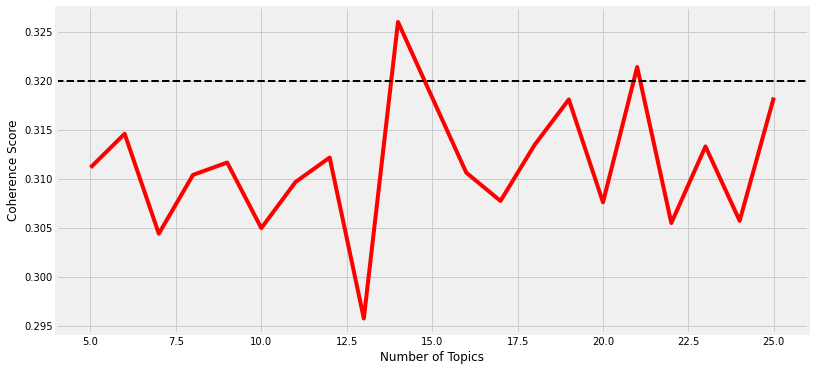

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
x_ax = range(5, 26, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.32, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 14].index[0]
best_nmf_model = nmf_models[best_model_idx]
best_nmf_model.num_topics

14

In [ ]:
topics = [[(term, round(wt, 3))
                        for term, wt in best_nmf_model.show_topic(n, topn=20)]
                        for n in range(0, best_nmf_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics],
                          columns = ['Term'+str(i) for i in range(1, 21)], 
                          index=['Topic '+str(t) for t in range(1, best_nmf_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14
Term1,horse,brother,old_man,get,man,child,princess,youth,king,sea,prince,son,princess,man
Term2,giant,father,daughter,man,great,old_man,prince,may,queen,ship,princess,mother,sultan,sultan
Term3,get,sister,old,wife,like,upon,queen,get,son,water,king,sultan,palace,thee
Term4,son,house,mother,think,eye,wolf,emperor,troll,daughter,great,think,great,lamp,answer
Term5,head,good,old_woman,want,heart,thee,fairy,must,princess,upon,great,may,magician,thy
Term6,back,wife,girl,ask,may,bear,bird,think,beautiful,giant,upon,reply,mother,brother
Term7,let,eye,three,back,hand,cry,may,ring,answer,fish,palace,palace,slave,thou
Term8,three,two,father,good,people,god,golden,long,father,sailor,soon,return,think,ask
Term9,water,poor,home,home,love,tree,cry,upon,hear,sail,good,place,never,reply
Term10,till,think,young,must,long,thy,upon,first,great,old,fairy,order,great,shall


In [ ]:
def lsi_coherence_generator(corpus, texts, dictionary, start_topic_count=2, 
                                    end_topic_count=10, step=1, cpus=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    lsi_model = gensim.models.LsiModel(corpus, id2word=dictionary, 
                                 num_topics=topic_nums, onepass=True, chunksize=1455, power_iters=2000)
    
    cv_coherence_model_lsi = gensim.models.CoherenceModel( model=lsi_model,
                                                      corpus=corpus,
                                                      texts=texts,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
    avg_coherence_cv = cv_coherence_model_lsi.get_coherence()
    coherence_scores.append(avg_coherence_cv)
    models.append(lsi_model)
  return models, coherence_scores

In [ ]:
lsi_models, coherence_scores_lsi = lsi_coherence_generator(corpus=bow_corpus,
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,
                                                                start_topic_count=5,
                                                                end_topic_count=20, step=1,
                                                                cpus=16)

100%|██████████| 16/16 [1:59:59<00:00, 449.95s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(5, 21, 1), 
                             'Coherence Score': np.round(coherence_scores_lsi, 4)})

coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
1,6,0.3669
0,5,0.3632
3,8,0.3624
6,11,0.3417
2,7,0.3396
5,10,0.3392
4,9,0.3309
10,15,0.3136
11,16,0.3119
12,17,0.3054


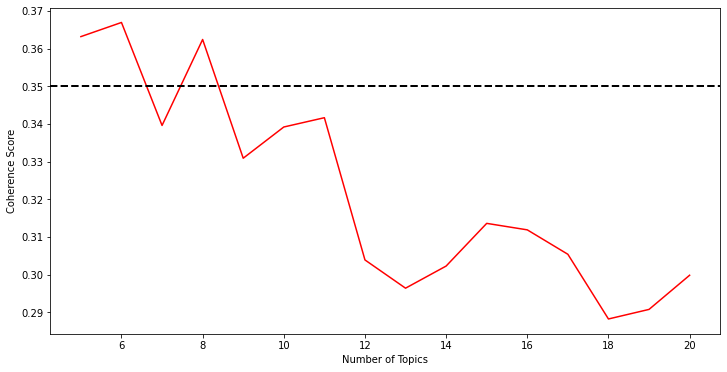

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
x_ax = range(5, 21, 1)
y_ax = coherence_scores_lsi
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.35, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 6].index[0]
best_lsi_model = lsi_models[best_model_idx]
best_lsi_model.num_topics

6

In [ ]:
topics_lsi = [[(term, round(wt, 3))
                        for term, wt in best_lsi_model.show_topic(n, topn=20)]
                        for n in range(0, best_lsi_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics_lsi],
                          columns = ['Term'+str(i) for i in range(1, 21)], 
                          index=['Topic '+str(t) for t in range(1, best_lsi_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Term1,king,king,king,prince,get,prince
Term2,princess,sultan,princess,king,upon,princess
Term3,prince,princess,prince,sultan,sea,son
Term4,great,palace,man,son,great,queen
Term5,man,mother,queen,mother,god,king
Term6,get,lamp,get,emperor,girl,giant
Term7,may,slave,wife,palace,home,sultan
Term8,think,magician,house,man,daughter,horse
Term9,good,man,fairy,fairy,man,cry
Term10,back,much,home,lamp,land,old_man


In [ ]:
def lda_coherence_generator(corpus, texts, dictionary, start_topic_count=2, 
                                    end_topic_count=10, step=1, cpus=1):
  models = []
  coherence_scores_lda = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, chunksize=1455,
                                   alpha='auto', eta='auto', random_state=42, iterations=2000, 
                                   num_topics=topic_nums, passes=20, eval_every=None)
    
    cv_coherence_model_lda = gensim.models.CoherenceModel( model=lda_model,
                                                        corpus=corpus,
                                                        texts=texts,
                                                        dictionary=dictionary,
                                                        coherence='c_v')
    avg_coherence_cv = cv_coherence_model_lda.get_coherence()
    coherence_scores_lda.append(avg_coherence_cv)
    models.append(lda_model)
  return models, coherence_scores_lda

In [ ]:
lda_models, coherence_scores_lda = lda_coherence_generator(corpus=bow_corpus,
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,
                                                                start_topic_count=5,
                                                                end_topic_count=25, step=1,
                                                                cpus=16)

100%|██████████| 21/21 [1:10:24<00:00, 201.16s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(5, 26, 1), 
                             'Coherence Score': np.round(coherence_scores_lda, 4)})

coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
14,19,0.3412
12,17,0.3359
10,15,0.3328
20,25,0.3291
15,20,0.3277
9,14,0.3269
18,23,0.3248
2,7,0.3247
13,18,0.3244
1,6,0.3232


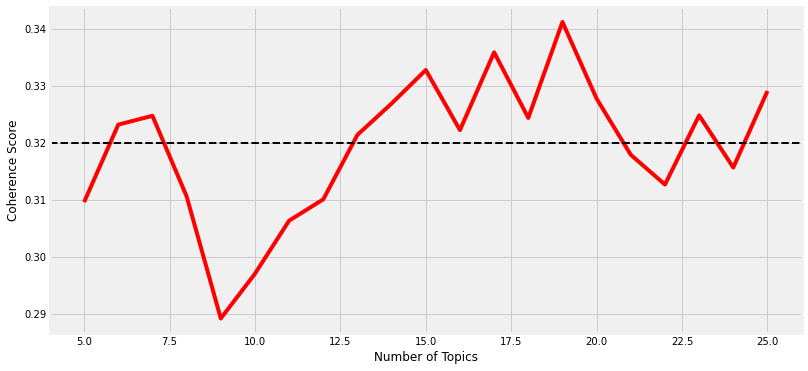

In [ ]:
%matplotlib inline
x_ax = range(5, 26, 1)
y_ax = coherence_scores_lda
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.32, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 19].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

19

In [ ]:
topics_lda = [[(term, round(wt, 3))
                        for term, wt in best_lda_model.show_topic(n, topn=20)]
                        for n in range(0, best_lda_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics_lda],
                          columns = ['Term'+str(i) for i in range(1, 21)], 
                          index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
Term1,man,upon,king,king,man,get,horse,man,sultan,giant,king,sea,man,king,thee,story,girl,god,cat
Term2,monkey,man,giant,queen,girl,good,prince,boy,princess,head,upon,fish,house,princess,thy,tale,daughter,man,get
Term3,mill,king,son,princess,miller,man,get,great,palace,castle,great,ship,get,prince,thou,also,mother,love,good
Term4,get,great,loki,prince,dwarf,think,ride,like,great,john,hear,water,wife,daughter,brother,three,sister,heart,child
Term5,turtle,two,odin,fairy,home,old_man,ask,bear,prince,youth,hand,man,back,ask,dog,devil,father,sigurd,eat
Term6,sack,place,great,upon,get,back,back,tree,may,man,long,like,jack,back,let,cf,sit,great,brother
Term7,fox,bring,put,think,mother,cry,brother,long,son,king,like,old,mother,castle,cry,pp,eye,yet,wood
Term8,ram,order,daughter,great,poor,wife,three,cat,much,thor,prince,dragon,night,three,tsar,russian,home,may,devil
Term9,crab,head,asgard,love,good,like,king,people,return,may,sea,wife,begin,youth,till,girl,beautiful,hand,think
Term10,mule,god,bear,good,think,old,home,back,emperor,like,eye,great,may,great,upon,two,two,earth,home


Из полученных результатов и метрик Coherence Score можно сделать вывод, что лучше всего выбрать модели LSI и LDA, но с разным количеством тем.

### Лучшие модели

In [ ]:
best_lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1455,
                                   alpha='auto', eta='auto', random_state=42, iterations=2000, 
                                   num_topics=19, passes=20, eval_every=None)

In [ ]:
best_lsi_model = gensim.models.LsiModel(bow_corpus, id2word=dictionary, 
                                 num_topics=6, onepass=True, chunksize=1455, power_iters=2000)

###Интерпретация результатов моделирования

Для проверки того, насколько хорошо работают модели, интерпретируем результаты их работы в более удобном и понятном виде.

In [ ]:
def base_stats(model, topics, corpus=bow_corpus):

  topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                          columns = ['Terms per Topic'],
                          index=['Topic'+str(t) for t in range(1, model.num_topics+1)])

  tm_results = model[bow_corpus]

  corpus_topics = [sorted(topics, key=lambda record: -record[1])[0]
                                                for topics in tm_results]
  corpus_topic_df = pd.DataFrame()
  corpus_topic_df['Document'] = range(0, len(corpus))

  corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
  corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]

  corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
  corpus_topic_df['Paper'] = fairy_tales
  return corpus_topic_df, topics_df

In [ ]:
corpus_topic_lsi, topics_df_lsi = base_stats(best_lsi_model, topics_lsi)
corpus_topic_lda, topics_df_lda =  base_stats(best_lda_model, topics_lda)

####Модель LSI

In [ ]:
# Распределение тем по текстам
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_lsi.groupby('Dominant Topic').agg(
                                      **{'Doc Count':('Dominant Topic',np.size), 
                                   '% Total Docs':('Dominant Topic',np.size)})

#topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(
                                lambda row: round((row*100) / len(bow_corpus), 2))
topic_stats_df['Topic Desc'] = [topics_df_lsi.iloc[t]['Terms per Topic'] for t in
                                                      range(len(topic_stats_df))]
topic_stats_df

,Doc Count,% Total Docs,Topic Desc
Dominant Topic,,,
1,1450,99.66,"king, princess, prince, great, man, get, may, think, good, back, ask, upon, like, son, leave, must, long, hear, father, two"
3,1,0.07,"king, sultan, princess, palace, mother, lamp, slave, magician, man, much, son, soon, grand_vizier, return, may, reply, majesty, great, present, immediately"
4,1,0.07,"king, princess, prince, man, queen, get, wife, house, fairy, home, good, palace, old_man, child, thee, old, boy, brother, eat, back"
5,2,0.14,"prince, king, sultan, son, mother, emperor, palace, man, fairy, lamp, tree, princess, slave, bird, sister, daughter, great, magician, answer, way"
6,1,0.07,"get, upon, sea, great, god, girl, home, daughter, man, land, heart, old_man, ask, old_woman, want, love, princess, eye, horse, wife"


Теперь видно, что несмотря на самые хорошие показатели метрик по сравнению с другими моделями, моделирование не прошло успешно: почти все тексты попали в одну категорию. Возможно, необходимо усовершенствование структуры набора данных и предобработки (например, стоп-слова для устаревшего английского).

####Модель LDA

In [ ]:
# Распределение тем по текстам
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_lda.groupby('Dominant Topic').agg(
                                      **{'Doc Count':('Dominant Topic',np.size), 
                                   '% Total Docs':('Dominant Topic',np.size)})

#topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(
                                lambda row: round((row*100) / len(bow_corpus), 2))
topic_stats_df['Topic Desc'] = [topics_df_lda.iloc[t]['Terms per Topic'] for t in
                                                      range(len(topic_stats_df))]
topic_stats_df

,Doc Count,% Total Docs,Topic Desc
Dominant Topic,,,
1,13,0.89,"man, monkey, mill, get, turtle, sack, fox, ram, crab, mule, good, tortoise, poor, ask, wife, rich, think, away, long, wind"
2,65,4.47,"upon, man, king, great, two, place, bring, order, head, god, long, city, hand, thee, may, thus, however, good, father, answer"
3,43,2.96,"king, giant, son, loki, odin, great, put, daughter, asgard, bear, house, back, head, leave, hand, get, thing, upon, man, father"
4,130,8.93,"king, queen, princess, prince, fairy, upon, think, great, love, good, cry, palace, much, long, hear, must, may, never, beautiful, soon"
5,25,1.72,"man, girl, miller, dwarf, home, get, mother, poor, good, think, house, child, seven, call, cry, away, dear, bed, lad, begin"
6,214,14.71,"get, good, man, think, old_man, back, cry, wife, like, old, poor, home, house, ask, run, must, begin, never, last, put"
7,36,2.47,"horse, prince, get, ride, ask, back, brother, three, king, home, son, prince_ivan, let, sit, like, mare, youth, master, golden, stable"
8,89,6.12,"man, boy, great, like, bear, tree, long, cat, people, back, dog, get, old, good, bird, wolf, call, think, hear, child"
9,22,1.51,"sultan, princess, palace, great, prince, may, son, much, return, emperor, leave, mother, reply, soon, good, place, ask, think, without, slave"


In [ ]:
# Примеры
import random
pd.set_option('display.max_colwidth', 200)
(corpus_topic_lda[corpus_topic_lda['Document'].isin(
    [random.randint(0,1455) for _ in range(10)])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
420,420,4,60.27,"king, queen, princess, prince, fairy, upon, think, great, love, good, cry, palace, much, long, hear, must, may, never, beautiful, soon","The King of the Low Countries was not a very scrupulous person, and his daughter took after him. This was why she had been changed into a serpent. It had been prophesied that she should be deliv..."
483,483,11,42.42,"king, upon, great, hear, hand, long, like, prince, sea, eye, old, night, love, cry, land, heart, may, never, mountain, pas","] 'Twit! twit,' cried a voice just above her; and the swallow fluttered to the ground beside her. 'You look sad; are you _really_ going to let that ugly mole marry you?' 'I shall soon die, that ..."
585,585,11,37.95,"king, upon, great, hear, hand, long, like, prince, sea, eye, old, night, love, cry, land, heart, may, never, mountain, pas","When Desire thought they could no longer catch him, he pulled his horse into a walk, like a prudent man who knows he has far to go. He travelled in this way for many weeks, passing by villages, ..."
774,774,9,76.15,"sultan, princess, palace, great, prince, may, son, much, return, emperor, leave, mother, reply, soon, good, place, ask, think, without, slave","There formerly reigned in the city of Harran a most magnificent and potent sultan, who loved his subjects, and was equally beloved by them. He was endued with all virtues, and wanted nothing to..."
967,967,13,49.57,"man, house, get, wife, back, jack, mother, night, begin, may, father, girl, child, good, leave, ask, great, place, think, must",". Kriza, xviii. The Hungarians have had a Dr. Faust in the person of Professor Hatvani, but in his case he got the best of the bargain; see _A Magyar Fauszt_, by Maurus Jókai. The Hungarian prof..."
1112,1112,2,65.20,"upon, man, king, great, two, place, bring, order, head, god, long, city, hand, thee, may, thus, however, good, father, answer","THE KING OF THE ANTS\n\n\nOnce upon a time there was a scholar, who wandered away from his home\nand went to Emmet village. There stood a house which was said to be\nhaunted. Yet it was beautifull..."
1225,1225,4,55.20,"king, queen, princess, prince, fairy, upon, think, great, love, good, cry, palace, much, long, hear, must, may, never, beautiful, soon","Violette was about to reply, when a kind of roaring was heard in the air, and they saw descend a chariot made of crocodile's skin, drawn by fifty enormous toads. All the toads were hissing and ..."
1250,1250,4,82.39,"king, queen, princess, prince, fairy, upon, think, great, love, good, cry, palace, much, long, hear, must, may, never, beautiful, soon","While Rosette was thus sleeping peacefully, the king, the queen, and Orangine and Roussette, purple with rage, were quarrelling and disputing amongst themselves. Each was accusing the other of ..."
1268,1268,8,71.61,"man, boy, great, like, bear, tree, long, cat, people, back, dog, get, old, good, bird, wolf, call, think, hear, child","was drawing nigh, and the Fianna-Finn had decided to hunt no more that day. The hounds were whistled to heel, and a sober, homeward march began. For men will walk soberly in the evening, however ..."
1325,1325,11,61.63,"king, upon, great, hear, hand, long, like, prince, sea, eye, old, night, love, cry, land, heart, may, never, mountain, pas","By the river Kingin stands the great stone image, or Miryek, that was cut out of the solid rock ages ago. Its base lies far beneath the ground and around its granite cap many feet square the st..."


Напротив, модель LDA справилась гораздо лучше. Видны явные тематики как скандинавские мифы и русские сказки. Также это видно по примерам текстов.

####Визуализация

In [ ]:
!pip install pyldavis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as pld_gns
import dill
import warnings

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()
pld_gns.prepare(best_lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.103381  0.031882       1        1  13.433398
13     0.034642 -0.030576       2        1  11.518898
5     -0.071516 -0.037984       3        1  10.568751
3      0.066882 -0.078751       4        1  10.102769
12     0.008041 -0.036731       5        1   8.608730
7     -0.001705  0.068119       6        1   6.112893
1      0.121324 -0.028438       7        1   5.111870
8      0.105940 -0.144913       8        1   4.788958
6     -0.030607 -0.010267       9        1   4.314200
16    -0.084865 -0.025214      10        1   3.839679
17     0.113212  0.163151      11        1   3.501277
11    -0.065774  0.065347      12        1   3.471914
2     -0.009334  0.073133      13        1   2.756558
14    -0.046193  0.052029      14        1   2.687899
18    -0.167465 -0.008890      15        1   2.319911
9     -0.006074  0.045038      16        1   2.166760
15     0.080024 -0.017431      17        1   2.098245
4     -0.066694 -0.027204      18        1   1.573844
0     -0.083220 -0.052299      19        1   1.023447, topic_info=         Term         Freq        Total Category  logprob  loglift
254      king  8751.000000  8751.000000  Default  30.0000  30.0000
295       man  6307.000000  6307.000000  Default  29.0000  29.0000
891  princess  4621.000000  4621.000000  Default  28.0000  28.0000
992     giant  1763.000000  1763.000000  Default  27.0000  27.0000
890    prince  4638.000000  4638.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
38      begin    51.628275  3046.467379  Topic19  -5.3043   0.5043
539       way    50.268216  3382.015889  Topic19  -5.3310   0.3731
32       back    50.618560  4525.391874  Topic19  -5.3241   0.0889
269     leave    48.546576  3534.512460  Topic19  -5.3659   0.2942
320      must    48.199767  3616.584267  Topic19  -5.3730   0.2641

[1382 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4130      1  0.201963   aboard
4130      6  0.040393   aboard
4130      8  0.161570   aboard
4130     12  0.565497   aboard
1334      1  0.113896  address
...     ...       ...      ...
2008     12  0.002162    youth
2008     13  0.004323    youth
2008     14  0.018735    youth
2008     16  0.125379    youth
2008     17  0.015852    youth

[8542 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 14, 6, 4, 13, 8, 2, 9, 7, 17, 18, 12, 3, 15, 19, 10, 16, 5, 1])

Таким образом, будем пользоваться моделью LDA для определения тем текстов из тестовой выборки.

###Предсказание тем текстов из тестовой выборки

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Dataset/test_data/'
test_tales = []
file_names = os.listdir(DATA_PATH)
for file_name in file_names:
    with open(DATA_PATH + file_name, encoding='utf-8', 
              errors='ignore', mode='r+') as f:
      data = f.read()
    test_tales.append(data)
len(test_tales)

197

In [ ]:
def text_preprocessing_pipeline(documents, normalizer_fn, normalizer_fn_2, bigram_model):
  for text in documents:
    chapter_pattern=re.compile(r'(CHAPTER [A-Z]+)|([Cc]hapter [A-Z]+)')
    decoration_pattern=re.compile(r'(\[Decoration])|(Decoration)')
    ill_pattern=re.compile(r'(\[Illustration:?[\s\w]*])|(Illustration)')
    text = re.sub(chapter_pattern, '', text)
    text = re.sub(ill_pattern, '', text)
    text = re.sub(decoration_pattern, '', text)

  norm_docs = normalizer_fn(documents)
  norm_docs = normalizer_fn_2(norm_docs)
  norm_docs_bigrams = bigram_model[norm_docs]
  return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
  paper_bow_features = [dictionary.doc2bow(text) for text in tokenized_docs]
  return paper_bow_features

In [ ]:
norm_test_tales = text_preprocessing_pipeline(documents=test_tales, 
                                              normalizer_fn=normalize_corpus, normalizer_fn_2=normalize_corpus_2, bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_test_tales,
                                          dictionary=dictionary)

In [ ]:
print(norm_test_tales[0][:30])

['return', 'long', 'journey', 'hero', 'undertake', 'expedition', 'amazon', 'order', 'finish', 'ninth', 'adventure', 'bring', 'king', 'eurystheus', 'sword', 'belt', 'amazon', 'hippolyta', 'amazon', 'inhabit', 'region', 'river', 'thermodon', 'race', 'strong', 'woman', 'follow', 'occupation', 'man', 'child']


In [ ]:
print(norm_bow_features[0][:30])

[(2, 2), (11, 1), (12, 1), (13, 1), (15, 2), (29, 1), (38, 1), (46, 1), (58, 1), (66, 1), (71, 1), (85, 2), (144, 3), (152, 4), (161, 3), (166, 1), (167, 2), (171, 1), (178, 1), (180, 1), (194, 1), (199, 1), (209, 1), (215, 1), (252, 1), (254, 1), (261, 1), (264, 1), (273, 1), (278, 2)]


In [ ]:
def get_topic_predictions(topic_model, corpus, topn=3):
  topic_predictions = topic_model[corpus]
  best_topics = [[(topic, round(wt, 3))
    for topic, wt in sorted(topic_predictions[i], key=lambda row: -row[1])[:topn]]
      for i in range(len(topic_predictions))]
  return best_topics

In [ ]:
topic_preds = get_topic_predictions(topic_model=best_lda_model, 
                                    corpus=norm_bow_features, topn=2)

In [ ]:
results_df = pd.DataFrame()
results_df['Tales'] = range(1, len(test_tales)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item]
                                                      for item in topic_preds]
res = results_df.set_index(['Tales'])['Dominant Topics'].apply(
                      pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in
                    [[round(wt*100, 2) for topic_num, wt in item]
                      for item in topic_preds]
                    for topic_wt in topic_list]
results_df['Topic Desc'] = [topics_df_lda.iloc[t-1]['Terms per Topic']
                                      for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [test_tales[i-1][:205] for i in results_df.index.values]

pd.set_option('display.max_colwidth', 300)
results_df

,Dominant Topics,Contribution %,Topic Desc,Paper Desc
Tales,,,,
1,2,34.4,"upon, man, king, great, two, place, bring, order, head, god, long, city, hand, thee, may, thus, however, good, father, answer","Returning from a long journey, the hero undertook an expedition against the Amazons in order to finish the ninth adventure and bring to King Eurystheus the sword belt of the Amazon Hippolyta. The Amazon"
1,11,26.5,"king, upon, great, hear, hand, long, like, prince, sea, eye, old, night, love, cry, land, heart, may, never, mountain, pas","Returning from a long journey, the hero undertook an expedition against the Amazons in order to finish the ninth adventure and bring to King Eurystheus the sword belt of the Amazon Hippolyta. The Amazon"
2,8,30.4,"man, boy, great, like, bear, tree, long, cat, people, back, dog, get, old, good, bird, wolf, call, think, hear, child","When the young queen Wilhelmina visited Brabant and Limburg, they amused her with pageants and plays, in which the little fellows called kabouters, in Dutch, and kobolds in German, played and showed off"
2,11,27.7,"king, upon, great, hear, hand, long, like, prince, sea, eye, old, night, love, cry, land, heart, may, never, mountain, pas","When the young queen Wilhelmina visited Brabant and Limburg, they amused her with pageants and plays, in which the little fellows called kabouters, in Dutch, and kobolds in German, played and showed off"
3,1,33.9,"man, monkey, mill, get, turtle, sack, fox, ram, crab, mule, good, tortoise, poor, ask, wife, rich, think, away, long, wind","Once on a time, but it was a long, long time ago, there were two brothers, one rich and one poor. Now, one Christmas eve, the poor one hadn't so much as a crumb in the house, either of meat or bread, so"
...,...,...,...,...
195,11,24.9,"king, upon, great, hear, hand, long, like, prince, sea, eye, old, night, love, cry, land, heart, may, never, mountain, pas",". Once on a time, Asa Thor and Loki set out on a journey from Asgard to Jötunheim. They travelled in Thor's chariot, drawn by two milk-white goats. It was a somewhat cumbrous iron chariot, and the wheels"
196,10,38.3,"giant, head, castle, john, youth, man, king, thor, may, like, two, stand, put, young_man, shepherd, great, tailor, dragon, monster, throw",".] ""Who are you?"" said Thor, standing on tiptoe, and stretching his neck to look up; ""and why do you make such a noise as to prevent your neighbours from sleeping?"" ""My name is Skrymir,"" said the giant s"
196,11,28.0,"king, upon, great, hear, hand, long, like, prince, sea, eye, old, night, love, cry, land, heart, may, never, mountain, pas",".] ""Who are you?"" said Thor, standing on tiptoe, and stretching his neck to look up; ""and why do you make such a noise as to prevent your neighbours from sleeping?"" ""My name is Skrymir,"" said the giant s"
